In [15]:
import os
import json
import sys

root_dir = os.path.join(os.getcwd(), "..")
sys.path.append(root_dir)

import torch
import torch.nn as nn
import random
import numpy as np

from torch.linalg import norm
from torchvision import models
from torch.linalg import norm
from src.data.get_dataloader import *
from src.model.save_nfm_agop import load_nn, get_grads, sqrt, patchify, get_nfm_agop
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

def min_max(M):
    return (M - M.min()) / (M.max() - M.min())

def transform_image(net, img, G, layer_idx=0):
    count = -1
    for idx, p in enumerate(net.parameters()):
        if len(p.shape) > 1:
            count += 1
        if count == layer_idx:
            M = p.data
            #print(M.shape)
            _, ki, q, s = M.shape

            M = M.reshape(-1, ki*q*s)
            M = torch.einsum('nd, nD -> dD', M, M)
            break

    count = 0
    l_idx = None
    for idx, m in enumerate(net.features):
        if isinstance(m, nn.Conv2d):
            #print(m, count)
            count += 1

        if count-1 == layer_idx:
            l_idx = idx
            break

    net.eval()
    net.cuda()
    img = img.cuda()
    img = net.features[:l_idx](img).cpu()
    net.cpu()

    if G is not None:
        M = G

    patches = patchify(img, (q, s), (1, 1))

    n, w, h, q, s, c = patches.shape
    patches = patches.reshape(n, w, h, q*s*c)
    M_patch = torch.einsum('nwhd, dD -> nwhD', patches, M)
    M_patch = norm(M_patch, dim=-1)
    
    return min_max(M_patch[0])

In [16]:
config_path = os.path.join("..", "config", "vgg11_config_py.json")
with open(config_path) as json_file:
    config = json.load(json_file)
#config

{'experiment_name': 'test',
 'data': {'path': './data',
  'dataset': 'cifar10',
  'image_channels': 1,
  'num_classes': 10,
  'batch_size': 64,
  'num_workers': 4,
  'val_split': 0.2},
 'agop_nfm': {'save_path': 'agop_nfm/',
  'pretrained': True,
  'model_path': 'models/cus_vgg.pth'},
 'model': {'type': 'vgg11',
  'num_blocks': [2, 2, 2, 2],
  'save_path': './models',
  'save_model': False,
  'init_method': 'nfm',
  'init_mean': 0.0,
  'init_std': 0.05,
  'agop_path': './agop',
  'nfm_path': './nfm',
  'pre_trained': False},
 'optimizer': {'type': 'sgd',
  'lr': 0.001,
  'momentum': 0.9,
  'weight_decay': 0.0005,
  'nestrov': False},
 'training': {'epochs': 15,
  'criterion': 'cross_entropy',
  'log_path': './logs'},
 'visualize': {'perform': False, 'save_path': './reports/figures/'}}

In [17]:
xiaohei = plt.imread("Xiaohei.jpg") #put example images
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            ])
original = transform(xiaohei)

In [19]:
net = models.vgg11(weights = "DEFAULT")
net.classifier[6] = nn.Linear(4096, 10, bias=True)
config["data"]["batch_size"] = 1
trainloader, valloader, testloader = get_dataloaders(config)

nfm_imgs = []
agop_imgs = []
agops = []
for layer_idx in range(4):
    M,G = get_nfm_agop(net,trainloader,layer_idx)
    agops.append(G)
    
for layer_idx in range(4):
    nfm_img = transform_image(net, original.unsqueeze(0), None, layer_idx=layer_idx).detach().numpy()
    agop_img = transform_image(net, original.unsqueeze(0), agops[layer_idx], layer_idx=layer_idx).detach().numpy()
    nfm_imgs.append(nfm_img)
    agop_imgs.append(agop_img)


Creating dataloaders...


100%|██████████| 170498071/170498071 [00:25<00:00, 6562885.78it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataloaders created


d:\anaconda\envs\deep\lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
d:\anaconda\envs\deep\lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


### Original Image

(-0.5, 223.5, 223.5, -0.5)

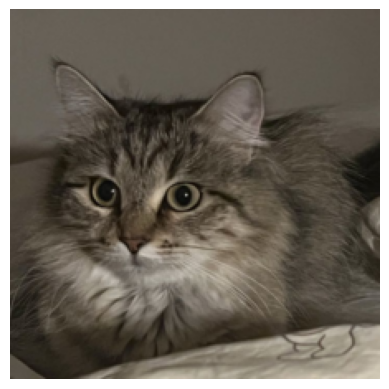

In [20]:
original = np.transpose(np.squeeze(original, axis=0), (1, 2, 0))
plt.imshow(original)
plt.axis("off")

### Transform Image

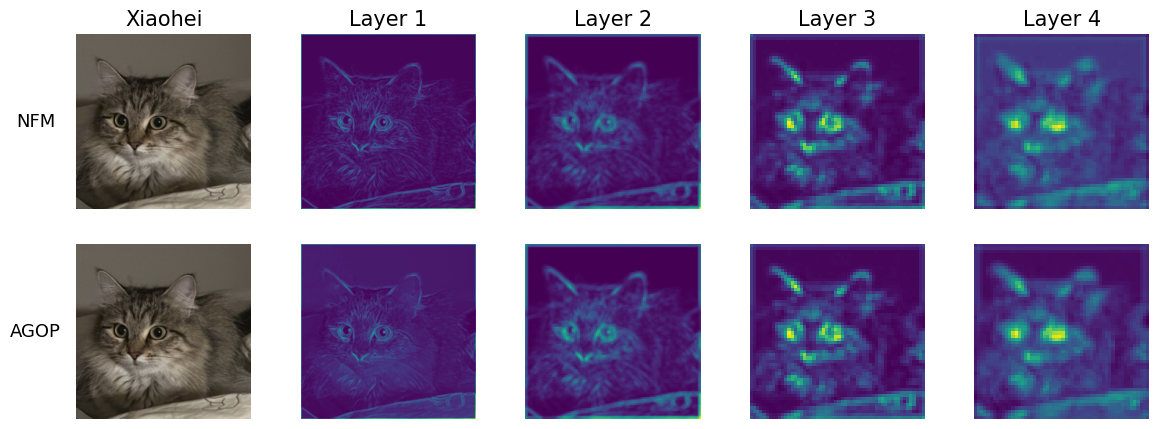

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(14, 5)) 

# Column titles
column_titles = ["Xiaohei",'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4']
for ax, col in zip(axes[0], column_titles):
    ax.set_title(col,size = 15)

# Row titles
row_titles = ['NFM', 'AGOP']
for ax, row in zip(axes[:,0], row_titles):
    fig.text(0.1, ax.get_position().y0 + ax.get_position().height/2, row,
             rotation='horizontal', va='center', ha='center',size = 13)

axes[0, 0].imshow(original)
axes[0, 0].axis('off')
axes[1, 0].imshow(original)
axes[1, 0].axis('off')
for i in range(4):
    axes[0, i+1].imshow(nfm_imgs[i])
    axes[0, i+1].axis('off')
    axes[1, i+1].imshow(agop_imgs[i])
    axes[1, i+1].axis('off')
plt.show()